# **Fake News Detection with NLP and LSTM**

**What is "Fake News"?**

“Fake news” is a term that has come to mean different things to different people. At its core, we are defining “fake news” as those news stories that are false: the story itself is fabricated, with no verifiable facts, sources or quotes. Sometimes these stories may be propaganda that is intentionally designed to mislead the reader, or may be designed as “clickbait” written for economic incentives (the writer profits on the number of people who click on the story). In recent years, fake news stories have proliferated via social media, in part because they are so easily and quickly shared online.

**About Dataset**

This data set consists of 40000 fake and real news. Our goal is to train our model to accurately predict whether a particular piece of news is real or fake. Fake and real news data are given in two separate data sets, with each data set consisting of approximately 20000 articles.

# Import Libararies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string 

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import keras
from tensorflow.keras.preprocessing import text,sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout

import warnings
warnings.filterwarnings('ignore')

**Load and Check the data**

In [2]:
real_data=pd.read_csv("True.csv")
fake_data=pd.read_csv("Fake.csv")

In [3]:
real_data.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
fake_data.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [5]:
#add column 
real_data['target'] = 1
fake_data['target'] = 0 

In [6]:
real_data.tail()

,title,text,subject,date,target
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017",1
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017",1
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017",1
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017",1
21416,Indonesia to buy $1.14 billion worth of Russia...,JAKARTA (Reuters) - Indonesia will buy 11 Sukh...,worldnews,"August 22, 2017",1


In [7]:
#Merging the 2 datasets
data = pd.concat([real_data, fake_data], ignore_index=True, sort=False)
data.head()

,title,text,subject,date,target
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [8]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
target     0
dtype: int64

# Visualization

**1.Count of Fake and Real Data**

target
0    23481
1    21417
Name: count, dtype: int64


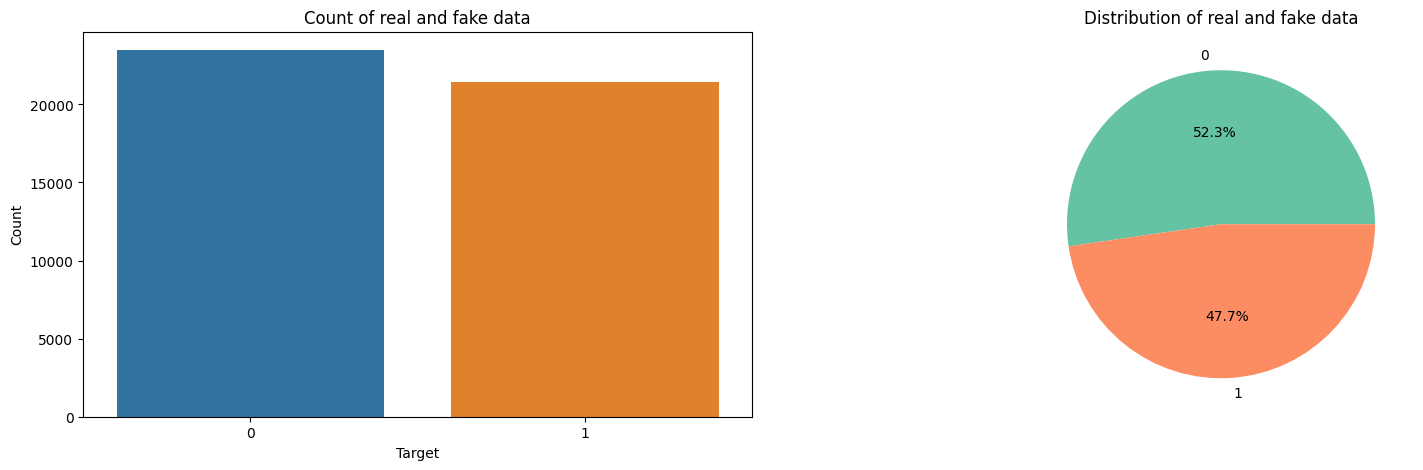

In [9]:
print(data["target"].value_counts())

fig, ax = plt.subplots(1, 2, figsize=(19, 5))

# Custom colors
countplot_colors = ["#1f77b4", "#ff7f0e"]   # blue + orange
pie_colors       = ["#66c2a5", "#fc8d62"]   # teal + coral

# Countplot
sns.countplot(x="target", data=data, ax=ax[0], palette=countplot_colors)
ax[0].set_title("Count of real and fake data")
ax[0].set_ylabel("Count")
ax[0].set_xlabel("Target")

# Pie chart
ax[1].pie(
    data["target"].value_counts().values,
    labels=data["target"].value_counts().index,
    autopct='%1.1f%%',
    colors=pie_colors,
    explode=[0, 0]
)
ax[1].set_title("Distribution of real and fake data")

plt.show()

**2.Distribution of The Subject According to Real and Fake Data**

subject
politicsNews       11272
worldnews          10145
News                9050
politics            6841
left-news           4459
Government News     1570
US_News              783
Middle-east          778
Name: count, dtype: int64


Text(0.5, 1.0, 'Distribution of The Subject According to Real and Fake Data')

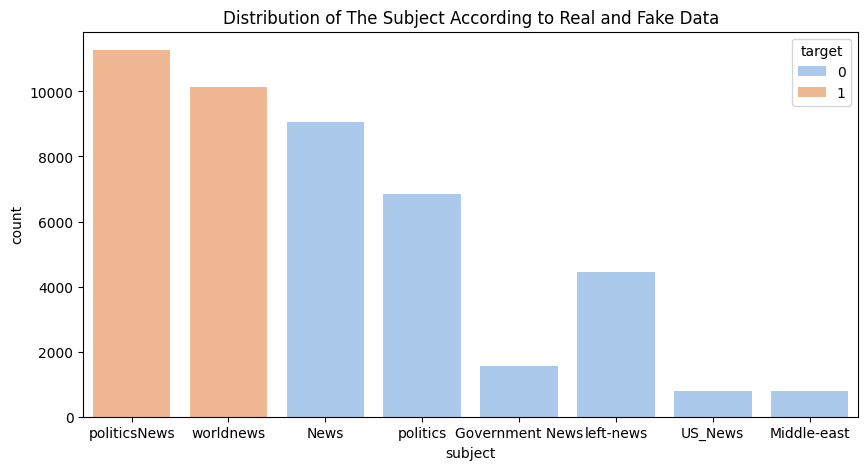

In [10]:
print(data.subject.value_counts())
plt.figure(figsize=(10, 5))

ax = sns.countplot(x="subject",  hue='target', data=data, palette="pastel")
plt.title("Distribution of The Subject According to Real and Fake Data")

# Data Cleaning

In [11]:
data['text']= data['subject'] + " " + data['title'] + " " + data['text']
del data['title']
del data['subject']
del data['date']
data.head()

,text,target
0,"politicsNews As U.S. budget fight looms, Repub...",1
1,politicsNews U.S. military to accept transgend...,1
2,politicsNews Senior U.S. Republican senator: '...,1
3,politicsNews FBI Russia probe helped by Austra...,1
4,politicsNews Trump wants Postal Service to cha...,1


In [12]:
first_text = data.text[10]
first_text

'politicsNews Jones certified U.S. Senate winner despite Moore challenge (Reuters) - Alabama officials on Thursday certified Democrat Doug Jones the winner of the state’s U.S. Senate race, after a state judge denied a challenge by Republican Roy Moore, whose campaign was derailed by accusations of sexual misconduct with teenage girls. Jones won the vacant seat by about 22,000 votes, or 1.6 percentage points, election officials said. That made him the first Democrat in a quarter of a century to win a Senate seat in Alabama.  The seat was previously held by Republican Jeff Sessions, who was tapped by U.S. President Donald Trump as attorney general. A state canvassing board composed of Alabama Secretary of State John Merrill, Governor Kay Ivey and Attorney General Steve Marshall certified the election results. Seating Jones will narrow the Republican majority in the Senate to 51 of 100 seats. In a statement, Jones called his victory “a new chapter” and pledged to work with both parties. M

# Removal of HTML Contents

**First, let's remove HTML content.**

In [13]:
# !pip install bs4

In [14]:
from bs4 import BeautifulSoup

soup = BeautifulSoup(first_text, "html.parser")
first_text = soup.get_text()
first_text

'politicsNews Jones certified U.S. Senate winner despite Moore challenge (Reuters) - Alabama officials on Thursday certified Democrat Doug Jones the winner of the state’s U.S. Senate race, after a state judge denied a challenge by Republican Roy Moore, whose campaign was derailed by accusations of sexual misconduct with teenage girls. Jones won the vacant seat by about 22,000 votes, or 1.6 percentage points, election officials said. That made him the first Democrat in a quarter of a century to win a Senate seat in Alabama.  The seat was previously held by Republican Jeff Sessions, who was tapped by U.S. President Donald Trump as attorney general. A state canvassing board composed of Alabama Secretary of State John Merrill, Governor Kay Ivey and Attorney General Steve Marshall certified the election results. Seating Jones will narrow the Republican majority in the Senate to 51 of 100 seats. In a statement, Jones called his victory “a new chapter” and pledged to work with both parties. M

# Removal of Punctuation Marks and Special Characters

**Let's now remove everything except uppercase / lowercase letters using Regular Expressions.**

In [15]:
first_text = re.sub('\[[^]]*\]', ' ', first_text)
first_text = re.sub('[^a-zA-Z]',' ',first_text)  # replaces non-alphabets with spaces
first_text = first_text.lower() # Converting from uppercase to lowercase
first_text

'politicsnews jones certified u s  senate winner despite moore challenge  reuters    alabama officials on thursday certified democrat doug jones the winner of the state s u s  senate race  after a state judge denied a challenge by republican roy moore  whose campaign was derailed by accusations of sexual misconduct with teenage girls  jones won the vacant seat by about        votes  or     percentage points  election officials said  that made him the first democrat in a quarter of a century to win a senate seat in alabama   the seat was previously held by republican jeff sessions  who was tapped by u s  president donald trump as attorney general  a state canvassing board composed of alabama secretary of state john merrill  governor kay ivey and attorney general steve marshall certified the election results  seating jones will narrow the republican majority in the senate to    of     seats  in a statement  jones called his victory  a new chapter  and pledged to work with both parties  m

# Removal of Stopwords

**Let's remove stopwords like is,a,the... Which do not offer much insight.**

In [16]:
nltk.download("stopwords")   
from nltk.corpus import stopwords  

# we can use tokenizer instead of split
first_text = nltk.word_tokenize(first_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\abhin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
first_text = [ word for word in first_text if not word in set(stopwords.words("english"))]

# Lemmatization

**Lemmatization to bring back multiple forms of same word to their common root like 'coming', 'comes' into 'come'.**

In [18]:
lemma = nltk.WordNetLemmatizer()
first_text = [ lemma.lemmatize(word) for word in first_text] 

first_text = " ".join(first_text)
first_text

'politicsnews jones certified u senate winner despite moore challenge reuters alabama official thursday certified democrat doug jones winner state u senate race state judge denied challenge republican roy moore whose campaign derailed accusation sexual misconduct teenage girl jones vacant seat vote percentage point election official said made first democrat quarter century win senate seat alabama seat previously held republican jeff session tapped u president donald trump attorney general state canvassing board composed alabama secretary state john merrill governor kay ivey attorney general steve marshall certified election result seating jones narrow republican majority senate seat statement jones called victory new chapter pledged work party moore declined concede defeat even trump urged stood claim fraudulent election statement released certification said regret medium outlet reported alabama judge denied moore request block certification result dec election decision shortly canvass

**Perform it for all the examples**

We performed the steps for a single example. Now let's perform it for all the examples in the data.

In [19]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def remove_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removal of punctuation marks
def remove_punctuations(text):
    return re.sub(r'[^\w\s]', '', text)

# Removal of special characters (non-alphanumeric)
def remove_characters(text):
    return re.sub(r'[^a-zA-Z]', ' ', text)

# Removal of stopwords and lemmatization
def remove_stopwords_and_lemmatization(text):
    final_text = []
    text = text.lower()
    words = nltk.word_tokenize(text)
    
    for word in words:
        if word not in stop_words:
            word = lemmatizer.lemmatize(word) 
            final_text.append(word)
    return " ".join(final_text)

# Complete cleaning pipeline
def cleaning(text):
    text = remove_html(text)
    text = remove_punctuations(text)
    text = remove_characters(text)
    text = remove_stopwords_and_lemmatization(text)
    return text

# Apply function to text column
data['text'] = data['text'].apply(cleaning)

In [20]:
data.head()

,text,target
0,politicsnews u budget fight loom republican fl...,1
1,politicsnews u military accept transgender rec...,1
2,politicsnews senior u republican senator let m...,1
3,politicsnews fbi russia probe helped australia...,1
4,politicsnews trump want postal service charge ...,1


# Let's make some visualization with new data.
**1.WordCloud for Real News**

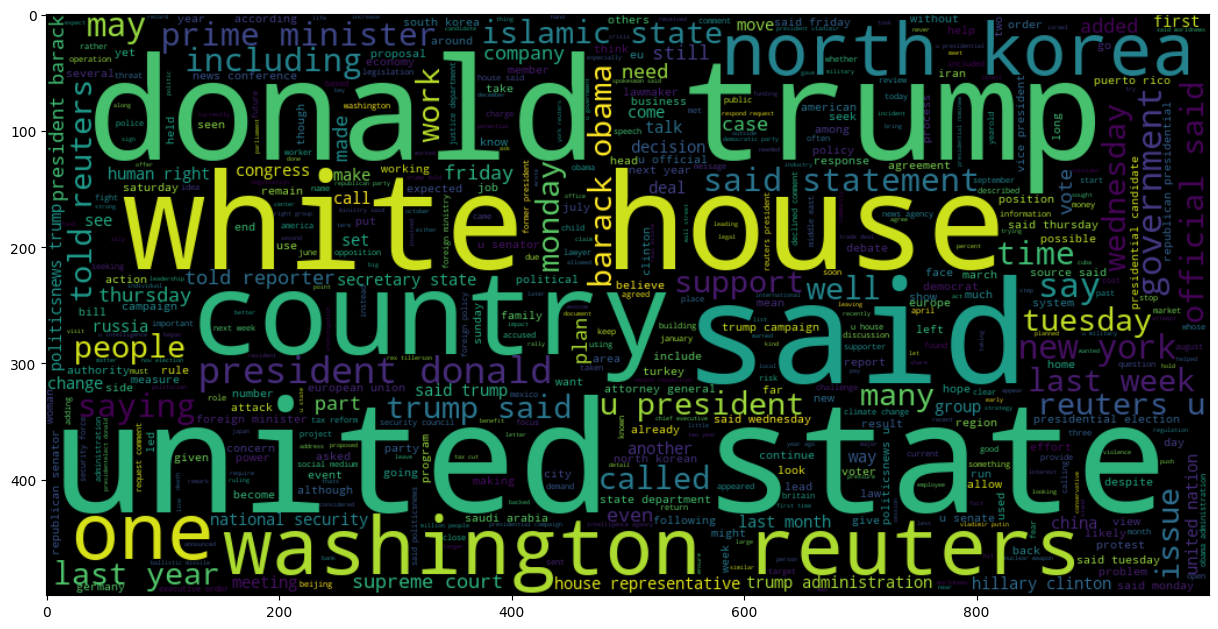

In [21]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.target == 1].text))
plt.imshow(wc , interpolation = 'bilinear')

**2.WordCloud for Fake News**

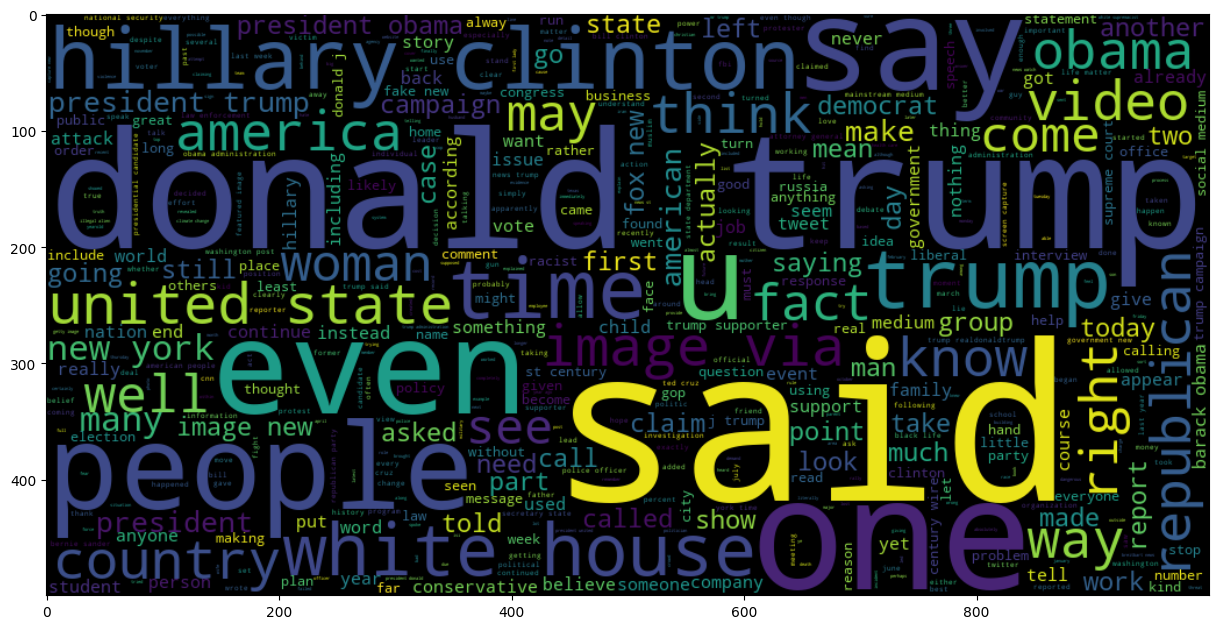

In [22]:
plt.figure(figsize = (15,15))
wc = WordCloud(max_words = 500 , width = 1000 , height = 500 , stopwords = STOPWORDS).generate(" ".join(data[data.target == 0].text))
plt.imshow(wc , interpolation = 'bilinear')

**Number of words in each text**

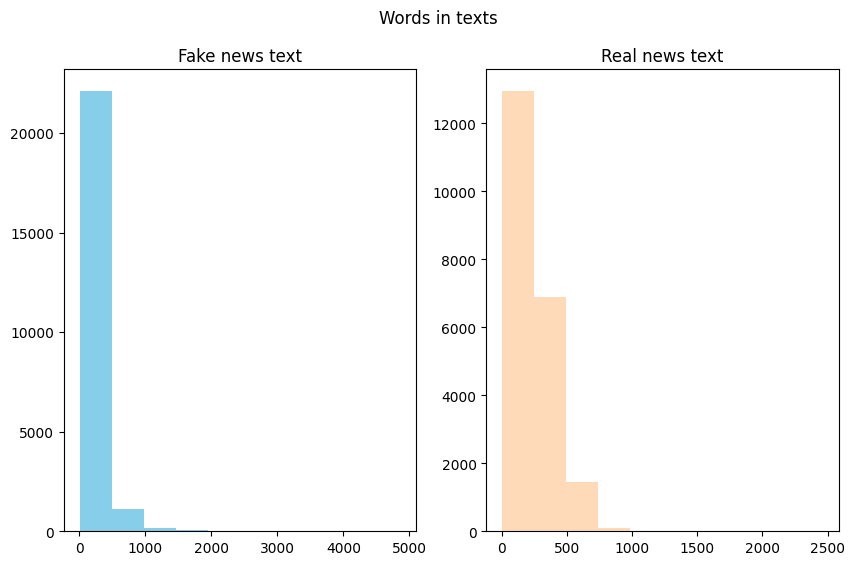

In [23]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,6))
text_len=data[data['target']==0]['text'].str.split().map(lambda x: len(x))
ax1.hist(text_len,color='SkyBlue')
ax1.set_title('Fake news text')
text_len=data[data['target']==1]['text'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='PeachPuff')
ax2.set_title('Real news text')
fig.suptitle('Words in texts')
plt.show()

**The number of words seems to be a bit different. 500 words are most common in real news category while around 250 words are most common in fake news category.**

**N-Gram Analysis**

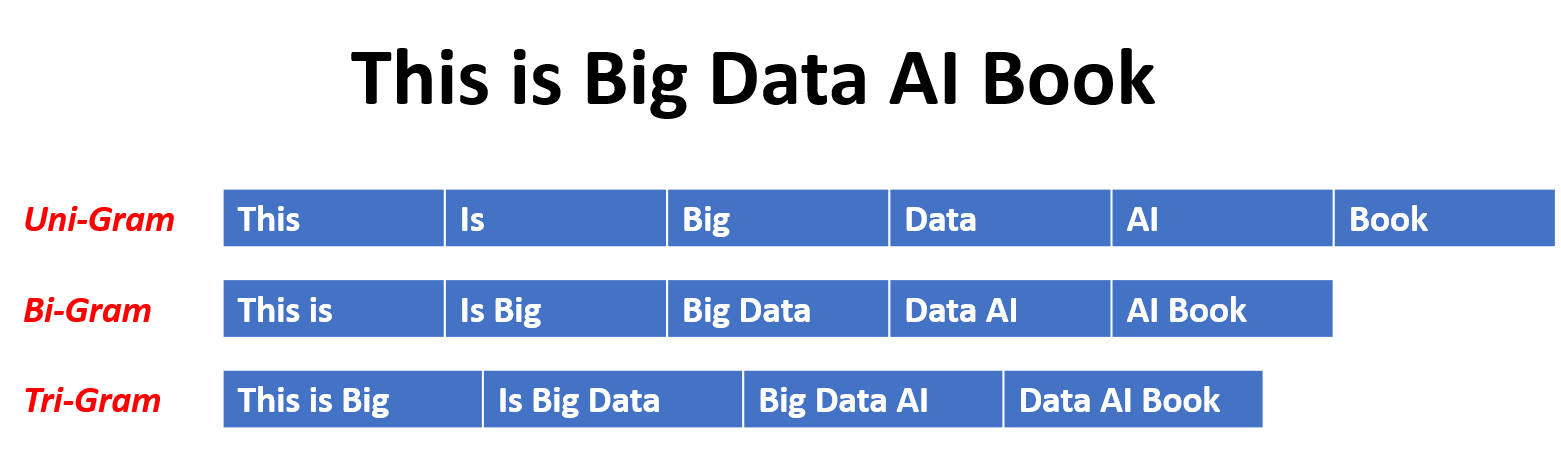

In [24]:
texts = ' '.join(data['text'])

In [25]:
string = texts.split(" ")

In [26]:
%matplotlib inline


In [31]:
def draw_n_gram(string,i):
    n_gram = (pd.Series(nltk.ngrams(string, i)).value_counts())[:15]
    n_gram_df=pd.DataFrame(n_gram)
    n_gram_df = n_gram_df.reset_index()
    n_gram_df = n_gram_df.rename(columns={"index": "word", 0: "count"})
    n_gram_df['word'] = n_gram_df['word'].apply(lambda x: ' '.join(x))
    print(n_gram_df.head())
    plt.figure(figsize = (16,9))
    return sns.barplot(x='count',y='word', data=n_gram_df, palette='coolwarm')

# Unigram Analysis

    word   count
0  trump  142847
1   said  130257
2      u   69598
3  state   59773
4  would   55429


<Axes: xlabel='count', ylabel='word'>

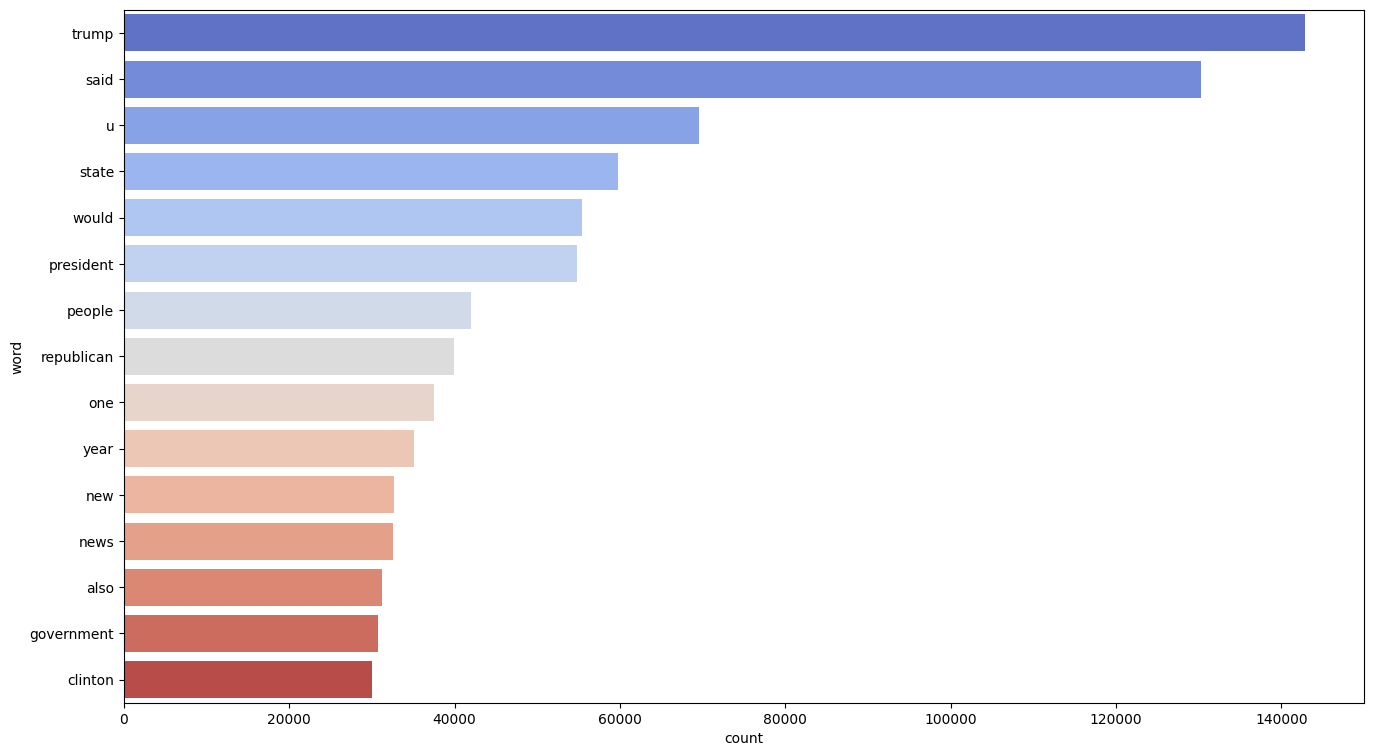

In [32]:
draw_n_gram(string,1)

# Bigram Analysis

              word  count
0     donald trump  24166
1     united state  18440
2      white house  15806
3  hillary clinton   9660
4         new york   8865


<Axes: xlabel='count', ylabel='word'>

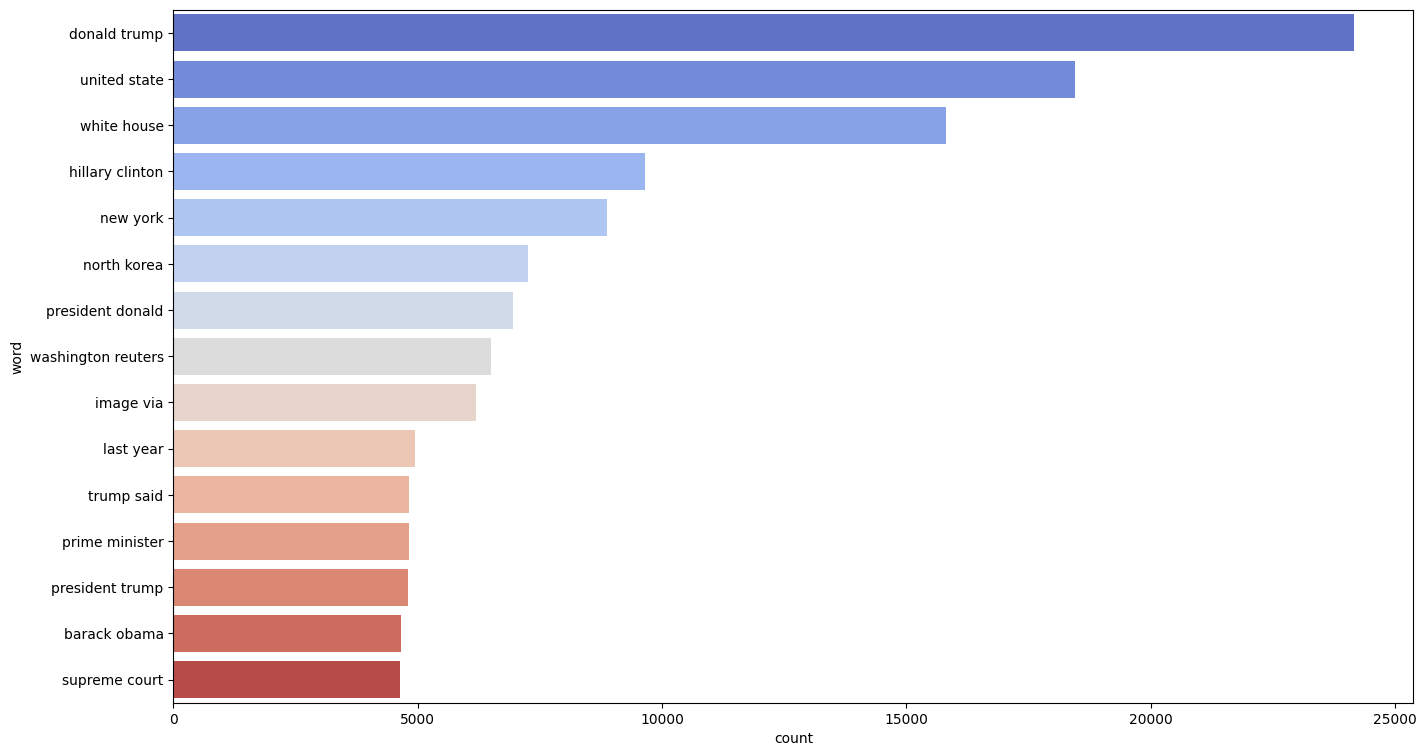

In [33]:
draw_n_gram(string,2)

# Trigram Analysis

                     word  count
0  president donald trump   6745
1  president barack obama   2863
2      u president donald   2590
3    washington reuters u   2358
4          donald j trump   2161


<Axes: xlabel='count', ylabel='word'>

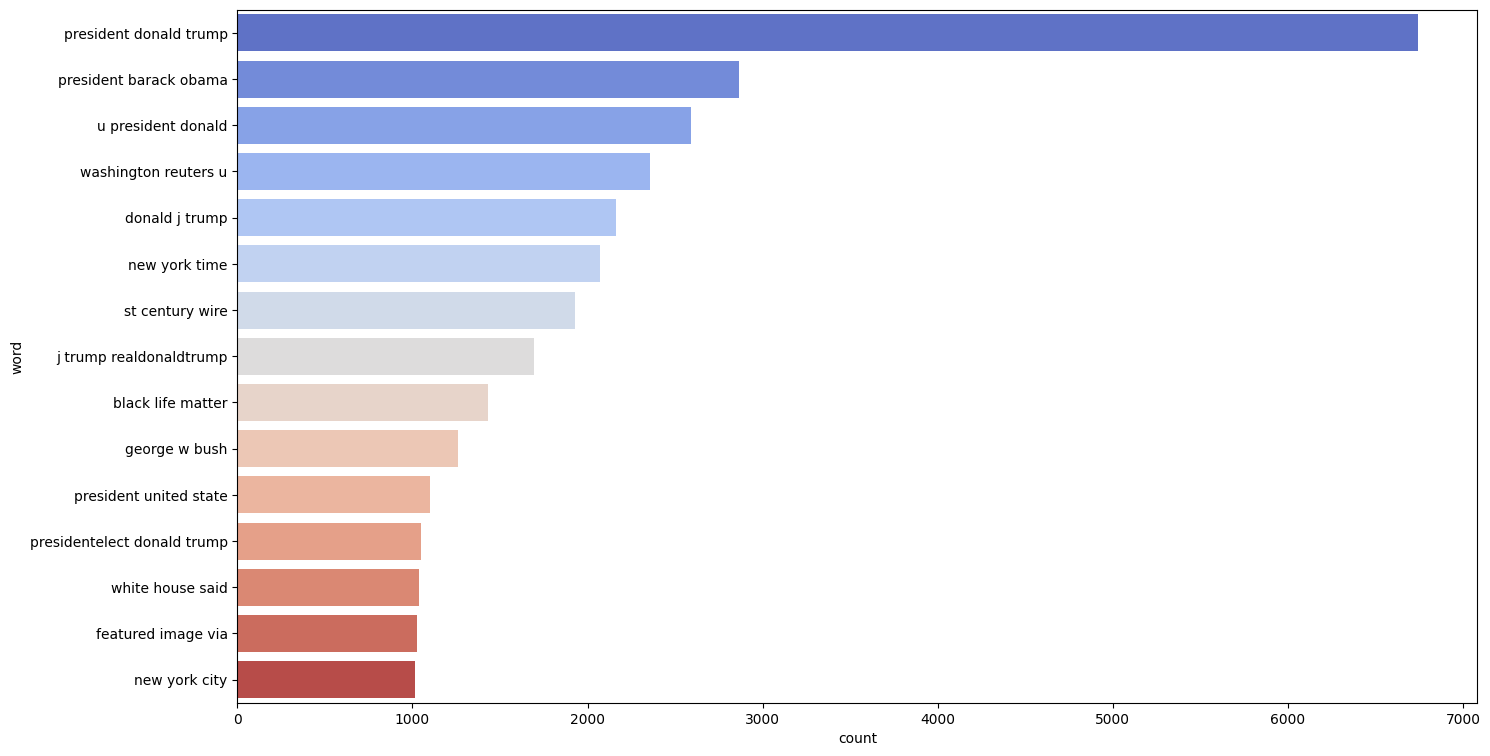

In [34]:
draw_n_gram(string,3)

# Modeling

**Train Test Split**

In [51]:
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['target'], random_state=0)

**Tokenizing**

* Tokenizing Text -> Repsesenting each word by a number
* Mapping of orginal word to number is preserved in word_index property of tokenizer

Lets keep all news to 300, add padding to news with less than 300 words and truncating long ones

In [52]:
max_features = 10000
maxlen = 300

In [53]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)
tokenized_train = tokenizer.texts_to_sequences(X_train)
X_train = sequence.pad_sequences(tokenized_train, maxlen=maxlen)

In [54]:
tokenized_test = tokenizer.texts_to_sequences(X_test)
X_test = sequence.pad_sequences(tokenized_test, maxlen=maxlen)

**Training LSTM Model**

In [55]:
batch_size = 256
epochs = 10
embed_size = 100

In [56]:
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(max_features, output_dim=embed_size, input_length=maxlen, trainable=False))
#LSTM 
model.add(LSTM(units=128 , return_sequences = True , recurrent_dropout = 0.25 , dropout = 0.25))
model.add(LSTM(units=64 , recurrent_dropout = 0.1 , dropout = 0.1))
model.add(Dense(units = 32 , activation = 'relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(learning_rate= 0.01), loss='binary_crossentropy', metrics=['accuracy'])

In [59]:
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)         │ (None, 300, 100)       │     1,000,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_12 (LSTM)                  │ (None, 300, 128)       │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,506,309 (5.75 MB)

 Trainable params: 168,769 (659.25 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

 Optimizer params: 337,540 (1.29 MB)

In [58]:
history = model.fit(X_train, y_train, validation_split=0.3, epochs=10, batch_size=batch_size, shuffle=True, verbose = 1)

Epoch 1/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 188s 2s/step - accuracy: 0.6829 - loss: 0.5771 - val_accuracy: 0.7831 - val_loss: 0.4574
Epoch 2/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 191s 2s/step - accuracy: 0.7870 - loss: 0.4312 - val_accuracy: 0.7606 - val_loss: 0.6766
Epoch 3/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.5793 - loss: 0.6727 - val_accuracy: 0.6413 - val_loss: 0.5619
Epoch 4/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.7244 - loss: 0.5154 - val_accuracy: 0.8124 - val_loss: 0.3931
Epoch 5/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 210s 2s/step - accuracy: 0.7986 - loss: 0.4158 - val_accuracy: 0.8756 - val_loss: 0.2970
Epoch 6/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 216s 2s/step - accuracy: 0.8559 - loss: 0.3269 - val_accuracy: 0.8941 - val_loss: 0.2643
Epoch 7/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 219s 2s/step - accuracy: 0.8833 - loss: 0.2807 - val_accuracy: 0.9363 - val_loss: 0.1675
Epoch 8/10
93/93 ━━━━━━━━━━━━━━━━━━━━ 223s 2s/step - accuracy: 0.9235 - loss: 0.2009 - val_accuracy: 0.9775 - v

# Analysis After Training

In [60]:
print("Accuracy of the model on Training Data is - " , model.evaluate(X_train,y_train)[1]*100 , "%")
print("Accuracy of the model on Testing Data is - " , model.evaluate(X_test,y_test)[1]*100 , "%")

1053/1053 ━━━━━━━━━━━━━━━━━━━━ 124s 117ms/step - accuracy: 0.9828 - loss: 0.0462
Accuracy of the model on Training Data is -  98.17658066749573 %
351/351 ━━━━━━━━━━━━━━━━━━━━ 40s 115ms/step - accuracy: 0.9791 - loss: 0.0575
Accuracy of the model on Testing Data is -  97.99554347991943 %


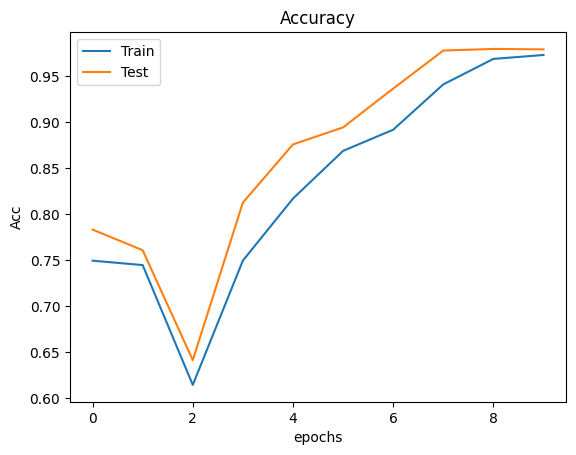

In [61]:
plt.figure()
plt.plot(history.history["accuracy"], label = "Train")
plt.plot(history.history["val_accuracy"], label = "Test")
plt.title("Accuracy")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

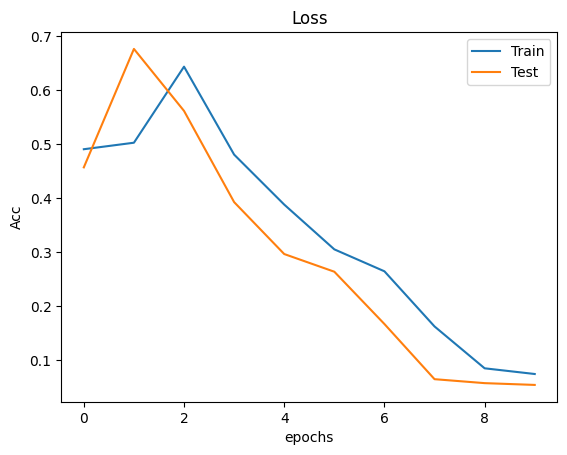

In [62]:
plt.figure()
plt.plot(history.history["loss"], label = "Train")
plt.plot(history.history["val_loss"], label = "Test")
plt.title("Loss")
plt.ylabel("Acc")
plt.xlabel("epochs")
plt.legend()
plt.show()

In [65]:
pred = model.predict(X_test)
y_pred=(pred>0.5).astype("int32")
print(classification_report(y_test, y_pred, target_names = ['Fake','Real']))

351/351 ━━━━━━━━━━━━━━━━━━━━ 38s 107ms/step
              precision    recall  f1-score   support

        Fake       0.97      0.99      0.98      5858
        Real       0.99      0.97      0.98      5367

    accuracy                           0.98     11225
   macro avg       0.98      0.98      0.98     11225
weighted avg       0.98      0.98      0.98     11225

